In [1]:
import torch
import torchvision
from torch.utils.data import random_split, Subset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# config
EPOCHS = 40
BATCH_SIZE = 64

config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
}

## Load data

In [3]:
# transform for training data with augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transform for validation and test data (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load train dataset
full_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=train_transform)

# load val dataset without augmentation (will be split below)
val_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=test_transform)

# split val dataset
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
# ensure the split is the same every time, so we set a generator
generator = torch.Generator().manual_seed(42)
trainset, valset_with_aug = random_split(full_trainset, [train_size, val_size], generator=generator)
# create final validation set by applying the validation indices to the non-augmented dataset
valset = Subset(val_dataset, valset_with_aug.indices)

# load the test dataset as before
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)

# create data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64,
                                          shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# get class names for CIFAR-100 (accessing from the original full dataset is safe)
classes = full_trainset.classes
print('Number of classes:', len(classes))
print('Example classes:', classes[:3])

100%|██████████| 169M/169M [00:14<00:00, 11.7MB/s]


Number of classes: 100
Example classes: ['apple', 'aquarium_fish', 'baby']


## CNN model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first CNN block
        self.conv1_1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(128)
        self.conv1_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        # second CNN block
        self.conv2_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(256)
        self.conv2_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)

        # third CNN block
        self.conv3_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        # FC layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout4 = nn.Dropout(0.2)
        self.bn_fc = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 100) # 100 classes

    def forward(self, x):
        # first CNN block
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # second CNN block
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # third CNN block
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # flatten
        x = torch.flatten(x, 1)

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.bn_fc(x)
        x = self.fc2(x)

        return x

net = Net()

In [5]:
# loss
config['loss'] = 'cross_entropy'
criterion = nn.CrossEntropyLoss()

# optimizer
config['optimizer'] = {
    'name': 'RMSprop',
    'learning_rate': 0.0001
}
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)

## Train

In [6]:
# get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# loss values for plotting
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    running_loss = 0.0

    net.train() # set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()

        # update
        optimizer.step()

        # statistics
        running_loss += loss.item()

    # average training loss for the epoch
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # validation loop
    net.eval() # set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad(): # disable gradient calculation during validation
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    # average validation loss for the epoch
    epoch_val_loss = val_running_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {epoch_train_loss:.3f}, Val Loss: {epoch_val_loss:.3f}')

Epoch [1/40], Train Loss: 4.004, Val Loss: 3.570
Epoch [2/40], Train Loss: 3.487, Val Loss: 3.045
Epoch [3/40], Train Loss: 3.078, Val Loss: 2.738
Epoch [4/40], Train Loss: 2.762, Val Loss: 2.474
Epoch [5/40], Train Loss: 2.544, Val Loss: 2.233
Epoch [6/40], Train Loss: 2.362, Val Loss: 2.147
Epoch [7/40], Train Loss: 2.220, Val Loss: 2.051
Epoch [8/40], Train Loss: 2.114, Val Loss: 1.908
Epoch [9/40], Train Loss: 2.014, Val Loss: 1.793
Epoch [10/40], Train Loss: 1.937, Val Loss: 1.773
Epoch [11/40], Train Loss: 1.866, Val Loss: 1.672
Epoch [12/40], Train Loss: 1.798, Val Loss: 1.661
Epoch [13/40], Train Loss: 1.743, Val Loss: 1.606
Epoch [14/40], Train Loss: 1.697, Val Loss: 1.573
Epoch [15/40], Train Loss: 1.642, Val Loss: 1.595
Epoch [16/40], Train Loss: 1.595, Val Loss: 1.563
Epoch [17/40], Train Loss: 1.553, Val Loss: 1.467
Epoch [18/40], Train Loss: 1.514, Val Loss: 1.450
Epoch [19/40], Train Loss: 1.474, Val Loss: 1.429
Epoch [20/40], Train Loss: 1.443, Val Loss: 1.411
Epoch [21

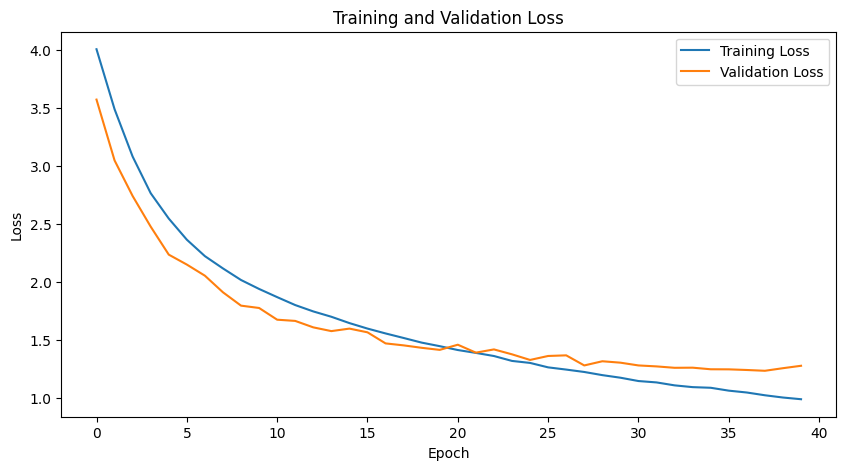

In [7]:
# plot for train and val loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluation

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

correct = 0
total = 0
all_labels = []
all_predicted = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        # forward pass
        outputs = net(images)

        # get predicted class (highest proba)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
precision = precision_score(all_labels, all_predicted, average='macro')
recall = recall_score(all_labels, all_predicted, average='macro')
f1 = f1_score(all_labels, all_predicted, average='macro')

print(f'Accuracy of the network on the {total} test images: {accuracy:.2f} %')
print(f'Precision (macro average): {precision:.2f}')
print(f'Recall (macro average): {recall:.2f}')
print(f'F1-score (macro average): {f1:.2f}')

results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

Accuracy of the network on the 10000 test images: 64.42 %
Precision (macro average): 0.66
Recall (macro average): 0.64
F1-score (macro average): 0.65
